# Predicting cell phenotypes using signaling signatures 
##                           Filtering insigificant phosphopeptides

In [1]:
import scipy as sp, numpy as np, pandas as pd, math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneOut
from numpy import random
from sklearn.cluster import KMeans
from Bio import SeqIO
from distance_calculation import Distance
from collections import defaultdict

## Importing Data

In [2]:
X = np.array(pd.read_csv('./MS_Initial_Data.csv', header=0))
Y = np.array(pd.read_csv('./Ydata.csv', header=0))
treatments = np.array(pd.read_csv('./MS_Initial_Data.csv', header=None))[0,2:]

peptide_phosphosite = X[:,0]
protein_description = X[:,1]
ProtNames = []
for item in protein_description:
    ProtName = item.split("OS")
    ProtName = ProtName[0]
    ProtNames.append(ProtName)
PC9 = X[:,2]
Erl = X[:,3]
R428 = X[:,4]
Erl_R428 = X[:,5]
Erl_HGF = X[:,6]
Erl_FGF = X[:,7]
Erl_IGF = X[:,8]
KO_Erl = X[:,9]
KO_R428 = X[:,10]
KO_Erl_R428 = X[:,11]

# Variables: X phosphopeptides 
X_ = np.concatenate([PC9,Erl,R428,Erl_R428,Erl_HGF,Erl_FGF,Erl_IGF,KO_Erl,KO_R428,KO_Erl_R428])
X_ = np.reshape(X_,(10,300))

# Observations:
# Y AXL expression
Y_axl = Y[:,3]
Y_axl = Y_axl[:10]

# Y cell viability
Y_cv = Y[:,2]
Y_cv = Y_cv[:10]

In [3]:
Y_axl_z = sp.stats.zscore(Y_axl)
Y_cv_z = sp.stats.zscore(Y_cv)

def zscore_columns(matrix):
    matrix_z = np.zeros((matrix.shape[0],matrix.shape[1]))
    for a in range(matrix.shape[1]):
        column = []
        column = matrix[:,a]
        column_mean = np.mean(column)
        column_std = np.std(column)
        matrix_z[:,a] = np.asmatrix([(column-column_mean)/column_std])
    return matrix_z

X_z = np.array(zscore_columns(X_.copy()))

## Determining Number of Components (Raw Data)

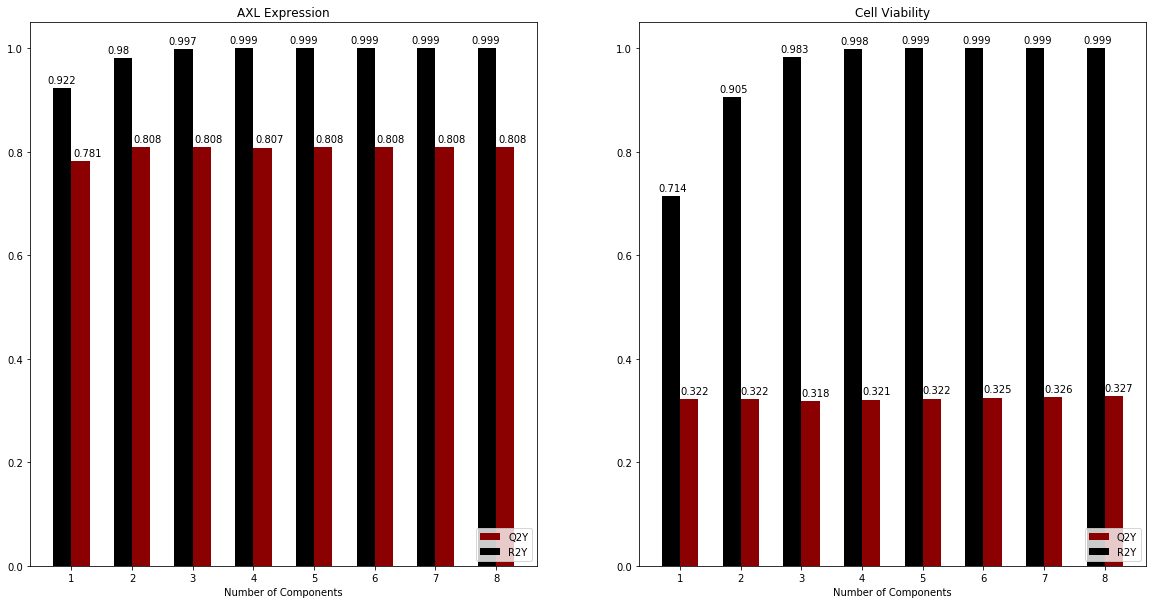

In [4]:
def R2Y_across_components(X_z,Y_z,max_comps,sublabel):
    R2Ys = []
    components = []
    for b in range(1,max_comps):
        plsr = PLSRegression(n_components = b)
        X_scores, Y_scores = plsr.fit_transform(X_z,Y_z)
        R2Y = plsr.score(X_z,Y_z)
        R2Ys.append(R2Y)
        components.append(b)
    return R2Ys

loo = LeaveOneOut()

def Q2Y_across_components(X_z,Y_z,max_comps,sublabel):
    PRESS = 0
    SS = 0
    Q2Ys = []
    for b in range(1,max_comps):
        plsr_model = PLSRegression(n_components = b)
        for train_index, test_index in loo.split(X_z, Y_z):
            X_train, X_test = X_z[train_index], X_z[test_index]
            Y_train, Y_test = Y_z[train_index], Y_z[test_index]
            X_train = zscore_columns(X_train)
            Y_train = sp.stats.zscore(Y_train)
            plsr_model.fit_transform(X_train,Y_train)
            Y_predict_cv = plsr_model.predict(X_test)
            PRESS_i = (Y_predict_cv - Y_test) ** 2
            SS_i = (Y_test) ** 2
            PRESS = PRESS + PRESS_i
            SS = SS + SS_i
        Q2Y = 1 - (PRESS/SS)
        Q2Ys.append(Q2Y)
    return Q2Ys
        
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,ax,spac1,spac2,dec):
    for l, m in enumerate(x):
        axs[ax].text(l+spac1,m+spac2,str(truncate(m,dec)))

Q2Y_axl = np.squeeze(Q2Y_across_components(X_z,Y_axl_z,9,'AXL Expression'))
Q2Y_cv = np.squeeze(Q2Y_across_components(X_z,Y_cv_z,9,'Cell Viability')) 
R2Y_axl = R2Y_across_components(X_z,Y_axl_z,9,'AXL Expression')
R2Y_cv = R2Y_across_components(X_z,Y_cv_z,9,'Cell Viability') 
range_ = np.linspace(1,8,8)

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].bar(range_+0.15,Q2Y_axl,width=0.3,align='center',label='Q2Y', color = "darkred")
axs[0].bar(range_-0.15,R2Y_axl,width=0.3,align='center',label='R2Y', color = "black")
axs[0].legend(loc=4)
axs[0].set(xlabel='Number of Components',title='AXL Expression')
disp_values(Q2Y_axl,0,1.03,0.01,3)
disp_values(R2Y_axl,0,0.6,0.01,3)
axs[1].bar(range_+0.15,Q2Y_cv,width=0.3,align='center',label='Q2Y', color = "darkred")
axs[1].bar(range_-0.15,R2Y_cv,width=0.3,align='center',label='R2Y', color = "black")
axs[1].set(xlabel='Number of Components',title='Cell Viability')
disp_values(Q2Y_cv,1,1,0.01,3)
disp_values(R2Y_cv,1,0.65,0.01,3)
axs[1].legend(loc=4)
plt.show()

In [5]:
def PLSR(X, Y, nComponents):
    plsr = PLSRegression(n_components = nComponents)
    X_scores, Y_scores = plsr.fit_transform(X,Y)
    PC1_scores, PC2_scores = X_scores[:,0], X_scores[:,1]
    PC1_xload, PC2_xload = plsr.x_loadings_[:,0], plsr.x_loadings_[:,1]
    PC1_yload, PC2_yload = plsr.y_loadings_[:,0], plsr.y_loadings_[:,1]
    return plsr, PC1_scores, PC2_scores, PC1_xload, PC2_xload, PC1_yload, PC2_yload

## Running PLSR for Each Phenotype (Raw Data)

In [6]:
plsr_axl_raw, PC1_scores, PC2_scores, PC1_xload, PC2_xload, PC1_yload, PC2_yload = PLSR(X_, Y_axl_z, 3)
plsr_cv_raw, PC1_scores, PC2_scores, PC1_xload, PC2_xload, PC1_yload, PC2_yload = PLSR(X_, Y_cv_z, 3)

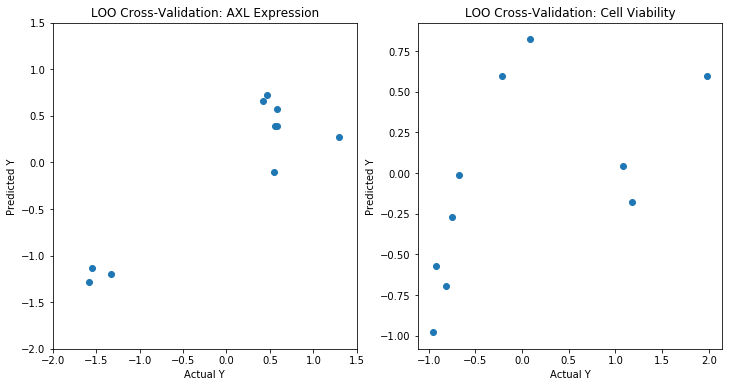

In [7]:
def cross_validation_plot(X,Y,plsr_model,ax,subtitle):
    Y_predictions = []
    for train_index, test_index in loo.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        X_train = zscore_columns(X_train)
        Y_train = sp.stats.zscore(Y_train)
        plsr_model.fit_transform(X_train,Y_train)
        Y_predict = plsr_model.predict(X_test)
        Y_predictions.append(Y_predict)
    Y_predictions = np.squeeze(Y_predictions)
    axs[ax].scatter(Y,np.squeeze(Y_predictions))
    axs[ax].set(title=subtitle,xlabel='Actual Y',ylabel='Predicted Y')   

fig, axs = plt.subplots(1,2,figsize=(12,6))
cross_validation_plot(X_z,Y_axl_z,plsr_axl_raw,0,'LOO Cross-Validation: AXL Expression')
axs[0].set_xlim([-2, 1.5])
axs[0].set_ylim([-2, 1.5])
cross_validation_plot(X_z,Y_cv_z,plsr_cv_raw,1,'LOO Cross-Validation: Cell Viability')
plt.show()

## Filtering insignificant phosphopeptides and K-means clustering

I'm currently filtering out any phosphopeptide whose phosphorylation levels don't change at least 2-fold (up or down) across any conditions 

In [8]:
def FilteringOutPeptides2(X):            
    NewX = []
    for i, row in enumerate(np.transpose(X)):
        if any(value >= 0.5 and value <= 2 for value in row):
            NewX.append(np.array(list(map(lambda x: np.log(x), row))))
    return np.squeeze(NewX)

X_F = FilteringOutPeptides2(X_)

In [9]:
def ClusterAverages_F(X_, nClusters, nObs):
    ClusterAvgs = []
    ClusterAvgs_arr = np.zeros((nClusters,nObs))
    for i in range(nClusters):
        CurrentCluster = []
        for idx, arr in enumerate(X_):
            if i == arr[0]:
                CurrentCluster.append(arr)
        CurrentCluster_T = np.transpose(CurrentCluster)
        CurrentAvgs = []
        for x, arr in enumerate(CurrentCluster_T):
            if x == 0:
                continue
            else:
                avg = np.mean(arr)
                CurrentAvgs.append(avg)
        ClusterAvgs_arr[i,:] = CurrentAvgs
        AvgsArr = np.transpose(ClusterAvgs_arr)
    return AvgsArr

##  Reimplementation of PLSR using Cluster Averages

## PLSR, 15 Clusters

In [10]:
kmeans = KMeans(n_clusters=15)
kmeans.fit(X_F)
clusters_F = kmeans.fit_predict(X_F)

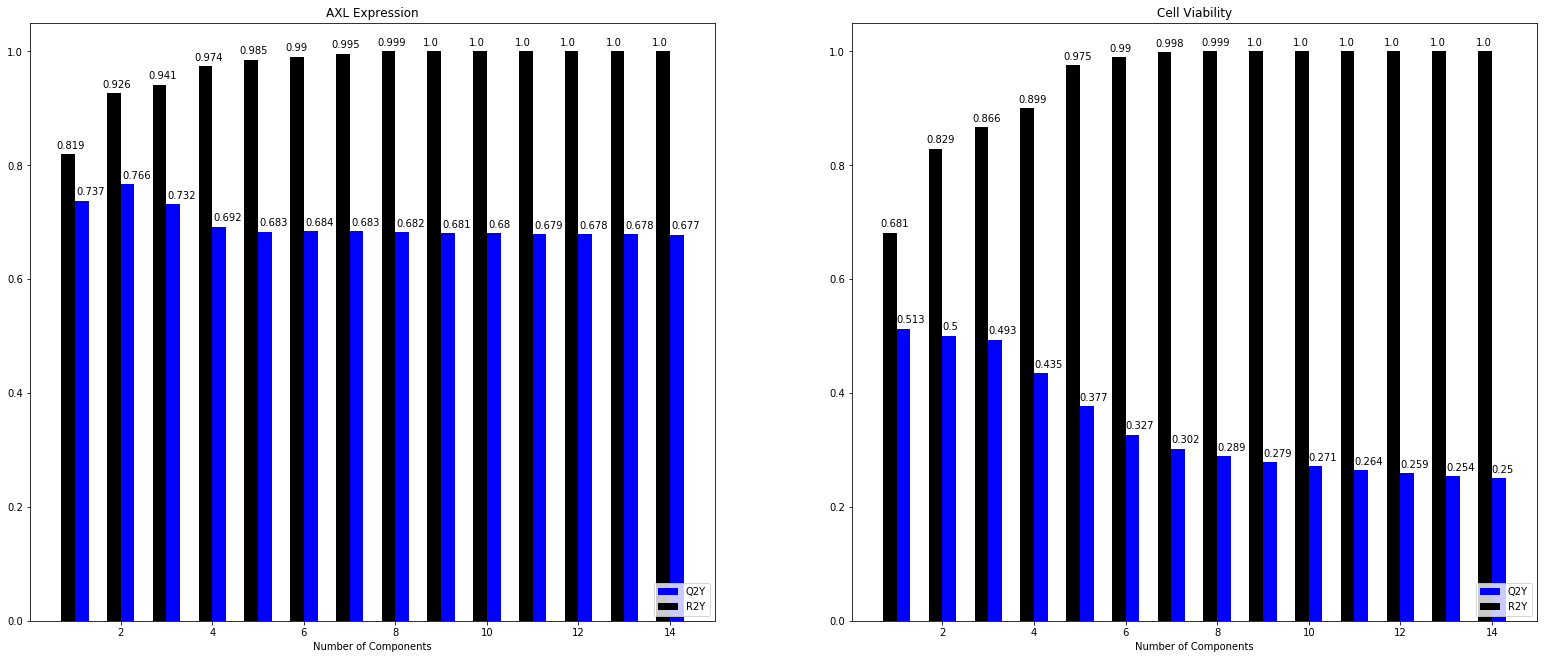

In [11]:
import warnings
warnings.simplefilter("ignore")

X_FCl = np.insert(np.transpose(X_F), 0, clusters_F, axis = 0)
X_FCl = np.transpose(X_FCl)

Cluster_Avgs_F = ClusterAverages_F(X_FCl, 15, 10)
X_ClusterAvgs_Fz = zscore_columns(Cluster_Avgs_F)

Q2Y_axlF = np.squeeze(Q2Y_across_components(X_ClusterAvgs_Fz,Y_axl_z,15,'AXL Expression'))
Q2Y_cvF = np.squeeze(Q2Y_across_components(X_ClusterAvgs_Fz,Y_cv_z,15,'Cell Viability')) 
R2Y_axlF = R2Y_across_components(X_ClusterAvgs_Fz,Y_axl_z,15,'AXL Expression')
R2Y_cvF = R2Y_across_components(X_ClusterAvgs_Fz,Y_cv_z,15,'Cell Viability') 

range_c = np.linspace(1,14,14)

fig, axs = plt.subplots(1,2,figsize=(27,11))
axs[0].bar(range_c+0.15,Q2Y_axlF,width=0.3,align='center',label='Q2Y', color = "blue")
axs[0].bar(range_c-0.15,R2Y_axlF,width=0.3,align='center',label='R2Y', color = "black")
axs[0].legend(loc=4)
axs[0].set(xlabel='Number of Components',title='AXL Expression')
disp_values(Q2Y_axlF,0,1.03,0.01,3)
disp_values(R2Y_axlF,0,0.6,0.01,3)
axs[1].bar(range_c+0.15,Q2Y_cvF,width=0.3,align='center',label='Q2Y', color = "blue")
axs[1].bar(range_c-0.15,R2Y_cvF,width=0.3,align='center',label='R2Y', color = "black")
axs[1].set(xlabel='Number of Components',title='Cell Viability')
disp_values(Q2Y_cvF,1,1,0.01,3)
disp_values(R2Y_cvF,1,0.65,0.01,3)
axs[1].legend(loc=4)
plt.show()

In [12]:
plsr_15axl, PC1_scores_15axl, PC2_scores_15axl, PC1_xload_15axl, PC2_xload_15axl, PC1_yload_15axl, PC2_yload_15axl = PLSR(X_ClusterAvgs_Fz, Y_axl_z, 3)
plsr_15cv, PC1_scores_15cv, PC2_scores_15cv, PC1_xload_15cv, PC2_xload_15cv, PC1_yload_15cv, PC2_yload_15cv = PLSR(X_ClusterAvgs_Fz, Y_cv_z, 3)

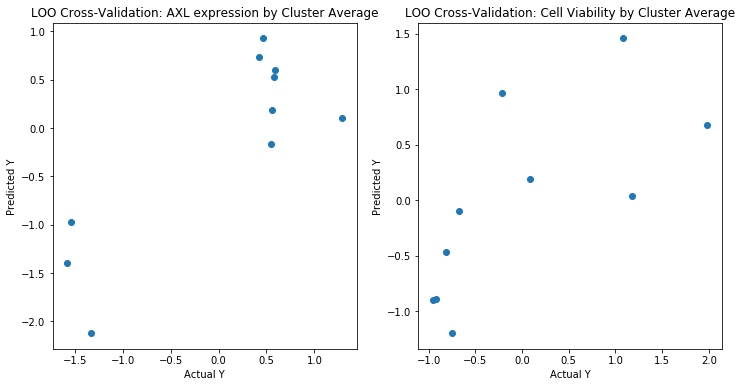

In [13]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
cross_validation_plot(X_ClusterAvgs_Fz,Y_axl_z,plsr_15axl,0,'LOO Cross-Validation: AXL expression by Cluster Average')
cross_validation_plot(X_ClusterAvgs_Fz,Y_cv_z,plsr_15cv,1,'LOO Cross-Validation: Cell Viability by Cluster Average')
plt.show()

### AXL and  Cell Viability results (15 clusters)

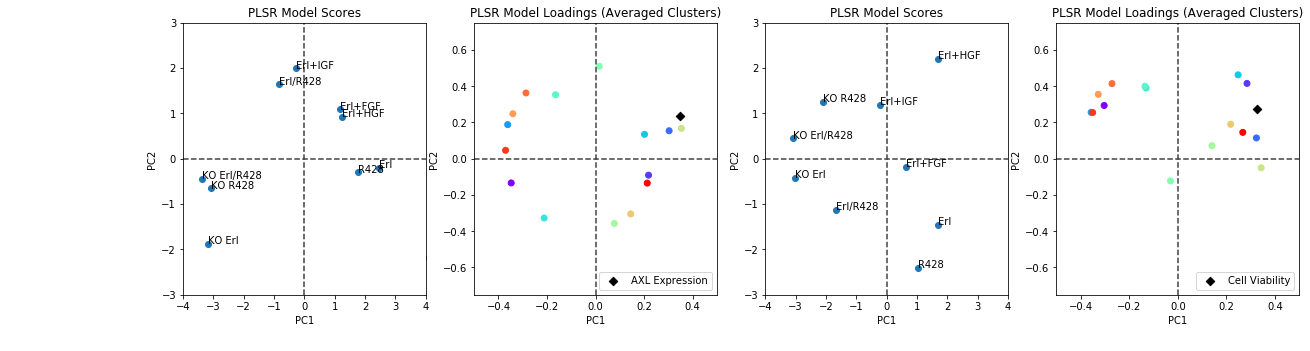

In [14]:
fig, axs = plt.subplots(1, 4,figsize=(20,5))
colors_ = cm.rainbow(np.linspace(0, 1, 15))
axs[0].scatter(PC1_scores_15axl,PC2_scores_15axl)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores_15axl[j], PC2_scores_15axl[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-4, 4])
axs[0].set_ylim([-3, 3])

axs[1].scatter(PC1_xload_15axl, PC2_xload_15axl, c=np.arange(15), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload_15axl, PC2_yload_15axl, color='#000000', marker='D', label='AXL Expression')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.5, 0.5])
axs[1].set_ylim([-0.75, 0.75])

axs[2].scatter(PC1_scores_15cv,PC2_scores_15cv)
for j, txt in enumerate(treatments):
    axs[2].annotate(txt, (PC1_scores_15cv[j], PC2_scores_15cv[j]))
axs[2].set_title('PLSR Model Scores')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')
axs[2].axhline(y=0, color='0.25', linestyle='--')
axs[2].axvline(x=0, color='0.25', linestyle='--')
axs[2].set_xlim([-4, 4])
axs[2].set_ylim([-3, 3])

axs[3].scatter(PC1_xload_15cv, PC2_xload_15cv, c=np.arange(15), cmap=colors.ListedColormap(colors_))
axs[3].scatter(PC1_yload_15cv, PC2_yload_15cv, color='#000000', marker='D', label='Cell Viability')
axs[3].legend(loc=4)
axs[3].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[3].set_xlabel('PC1')
axs[3].set_ylabel('PC2')
axs[3].axhline(y=0, color='0.25', linestyle='--')
axs[3].axvline(x=0, color='0.25', linestyle='--')
axs[3].set_xlim([-0.5, 0.5])
axs[3].set_ylim([-0.75, 0.75])
plt.show()

## PLSR, 10 Clusters

### AXL and  Cell Viability results (10 clusters)

In [15]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_F)
clusters_F = kmeans.fit_predict(X_F)

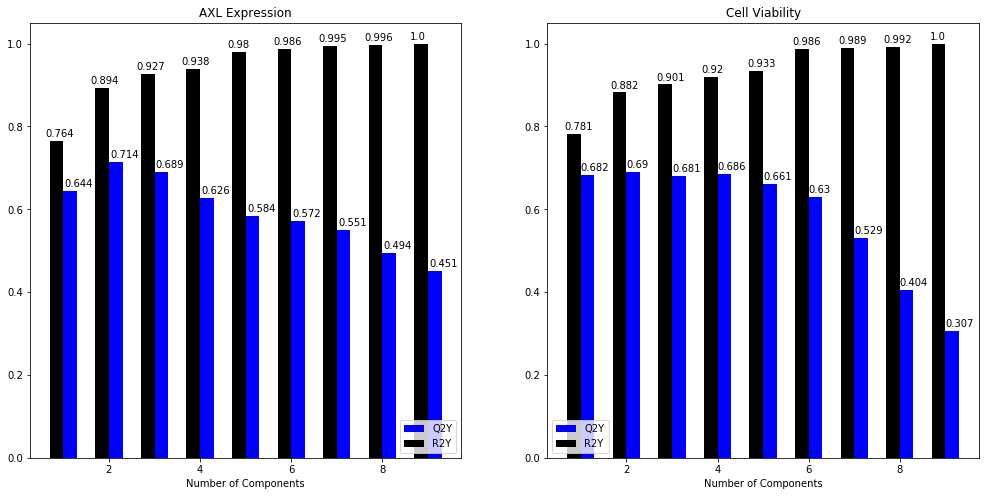

In [16]:
import warnings
warnings.simplefilter("ignore")

X_FCl = np.insert(np.transpose(X_F), 0, clusters_F, axis = 0)
X_FCl = np.transpose(X_FCl)

Cluster_Avgs_F = ClusterAverages_F(X_FCl, 10, 10)
X_ClusterAvgs_Fz = zscore_columns(Cluster_Avgs_F)

Q2Y_axlF = np.squeeze(Q2Y_across_components(X_ClusterAvgs_Fz,Y_axl_z,10,'AXL Expression'))
Q2Y_cvF = np.squeeze(Q2Y_across_components(X_ClusterAvgs_Fz,Y_cv_z,10,'Cell Viability')) 
R2Y_axlF = R2Y_across_components(X_ClusterAvgs_Fz,Y_axl_z,10,'AXL Expression')
R2Y_cvF = R2Y_across_components(X_ClusterAvgs_Fz,Y_cv_z,10,'Cell Viability') 

range_c = np.linspace(1,9,9)

fig, axs = plt.subplots(1,2,figsize=(17,8))
axs[0].bar(range_c+0.15,Q2Y_axlF,width=0.3,align='center',label='Q2Y', color = "blue")
axs[0].bar(range_c-0.15,R2Y_axlF,width=0.3,align='center',label='R2Y', color = "black")
axs[0].legend(loc=4)
axs[0].set(xlabel='Number of Components',title='AXL Expression')
disp_values(Q2Y_axlF,0,1.03,0.01,3)
disp_values(R2Y_axlF,0,0.6,0.01,3)
axs[1].bar(range_c+0.15,Q2Y_cvF,width=0.3,align='center',label='Q2Y', color = "blue")
axs[1].bar(range_c-0.15,R2Y_cvF,width=0.3,align='center',label='R2Y', color = "black")
axs[1].set(xlabel='Number of Components',title='Cell Viability')
disp_values(Q2Y_cvF,1,1,0.01,3)
disp_values(R2Y_cvF,1,0.65,0.01,3)
axs[1].legend(loc=3)
plt.show()

In [17]:
plsr_10axl, PC1_scores_10axl, PC2_scores_10axl, PC1_xload_10axl, PC2_xload_10axl, PC1_yload_10axl, PC2_yload_10axl = PLSR(X_ClusterAvgs_Fz, Y_axl_z, 3)
plsr_10cv, PC1_scores_10cv, PC2_scores_10cv, PC1_xload_10cv, PC2_xload_10cv, PC1_yload_10cv, PC2_yload_10cv = PLSR(X_ClusterAvgs_Fz, Y_cv_z, 3)

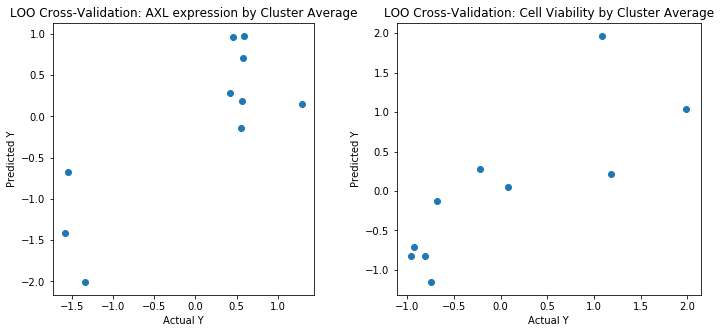

In [18]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
cross_validation_plot(X_ClusterAvgs_Fz,Y_axl_z,plsr_10axl,0,'LOO Cross-Validation: AXL expression by Cluster Average')
cross_validation_plot(X_ClusterAvgs_Fz,Y_cv_z,plsr_10cv,1,'LOO Cross-Validation: Cell Viability by Cluster Average')
axs[0].set_aspect('equal')
plt.show()

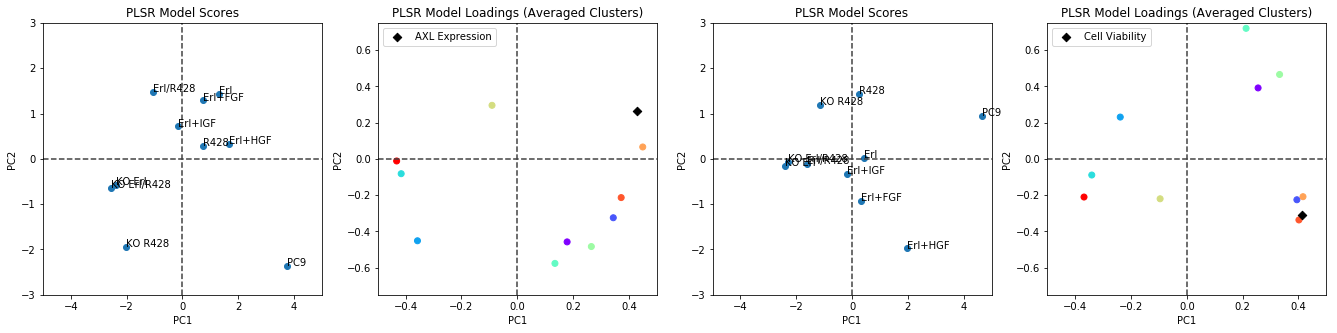

In [19]:
fig, axs = plt.subplots(1, 4,figsize=(23,5))
colors_ = cm.rainbow(np.linspace(0, 1, 10))
axs[0].scatter(PC1_scores_10axl,PC2_scores_10axl)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores_10axl[j], PC2_scores_10axl[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-3, 3])

axs[1].scatter(PC1_xload_10axl, PC2_xload_10axl, c=np.arange(10), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload_10axl, PC2_yload_10axl, color='#000000', marker='D', label='AXL Expression')
axs[1].legend(loc=2)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.5, 0.5])
axs[1].set_ylim([-0.75, 0.75])

axs[2].scatter(PC1_scores_10cv,PC2_scores_10cv)
for j, txt in enumerate(treatments):
    axs[2].annotate(txt, (PC1_scores_10cv[j], PC2_scores_10cv[j]))
axs[2].set_title('PLSR Model Scores')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')
axs[2].axhline(y=0, color='0.25', linestyle='--')
axs[2].axvline(x=0, color='0.25', linestyle='--')
axs[2].set_xlim([-5, 5])
axs[2].set_ylim([-3, 3])

axs[3].scatter(PC1_xload_10cv, PC2_xload_10cv, c=np.arange(10), cmap=colors.ListedColormap(colors_))
axs[3].scatter(PC1_yload_10cv, PC2_yload_10cv, color='#000000', marker='D', label='Cell Viability')
axs[3].legend(loc=2)
axs[3].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[3].set_xlabel('PC1')
axs[3].set_ylabel('PC2')
axs[3].axhline(y=0, color='0.25', linestyle='--')
axs[3].axvline(x=0, color='0.25', linestyle='--')
axs[3].set_xlim([-0.5, 0.5])
axs[3].set_ylim([-0.75, 0.75])
plt.show()

## PLSR, 5 Clusters

In [20]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_F)
clusters_F = kmeans.fit_predict(X_F)

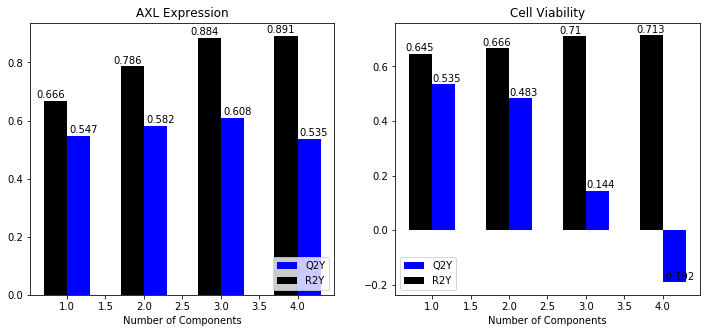

In [21]:
X_FCl = np.insert(np.transpose(X_F), 0, clusters_F, axis = 0)
X_FCl = np.transpose(X_FCl)

Cluster_Avgs_F = ClusterAverages_F(X_FCl, 5, 10)
X_ClusterAvgs_Fz = zscore_columns(Cluster_Avgs_F)

Q2Y_axlF = np.squeeze(Q2Y_across_components(X_ClusterAvgs_Fz,Y_axl_z,5,'AXL Expression'))
Q2Y_cvF = np.squeeze(Q2Y_across_components(X_ClusterAvgs_Fz,Y_cv_z,5,'Cell Viability')) 
R2Y_axlF = R2Y_across_components(X_ClusterAvgs_Fz,Y_axl_z,5,'AXL Expression')
R2Y_cvF = R2Y_across_components(X_ClusterAvgs_Fz,Y_cv_z,5,'Cell Viability') 

range_c = np.linspace(1,4,4)

fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].bar(range_c+0.15,Q2Y_axlF,width=0.3,align='center',label='Q2Y', color = "blue")
axs[0].bar(range_c-0.15,R2Y_axlF,width=0.3,align='center',label='R2Y', color = "black")
axs[0].legend(loc=4)
axs[0].set(xlabel='Number of Components',title='AXL Expression')
disp_values(Q2Y_axlF,0,1.03,0.01,3)
disp_values(R2Y_axlF,0,0.6,0.01,3)
axs[1].bar(range_c+0.15,Q2Y_cvF,width=0.3,align='center',label='Q2Y', color = "blue")
axs[1].bar(range_c-0.15,R2Y_cvF,width=0.3,align='center',label='R2Y', color = "black")
axs[1].set(xlabel='Number of Components',title='Cell Viability')
disp_values(Q2Y_cvF,1,1,0.01,3)
disp_values(R2Y_cvF,1,0.65,0.01,3)
axs[1].legend(loc=3)
plt.show()

In [22]:
plsr_5axl, PC1_scores_5axl, PC2_scores_5axl, PC1_xload_5axl, PC2_xload_5axl, PC1_yload_5axl, PC2_yload_5axl = PLSR(X_ClusterAvgs_Fz, Y_axl_z, 3)
plsr_5cv, PC1_scores_5cv, PC2_scores_5cv, PC1_xload_5cv, PC2_xload_5cv, PC1_yload_5cv, PC2_yload_5cv = PLSR(X_ClusterAvgs_Fz, Y_cv_z, 3)

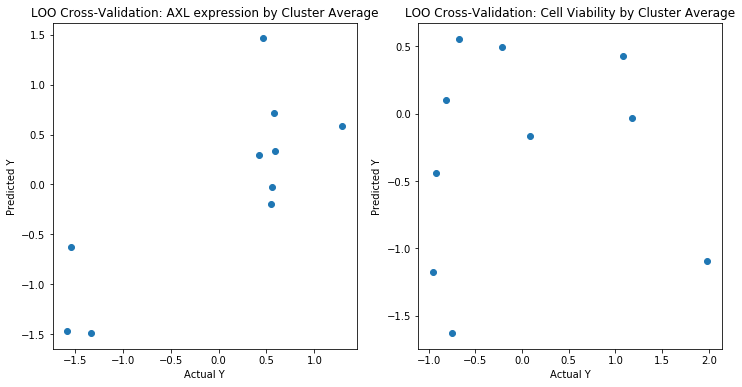

In [23]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
cross_validation_plot(X_ClusterAvgs_Fz,Y_axl_z,plsr_5axl,0,'LOO Cross-Validation: AXL expression by Cluster Average')
cross_validation_plot(X_ClusterAvgs_Fz,Y_cv_z,plsr_5cv,1,'LOO Cross-Validation: Cell Viability by Cluster Average')
plt.show()

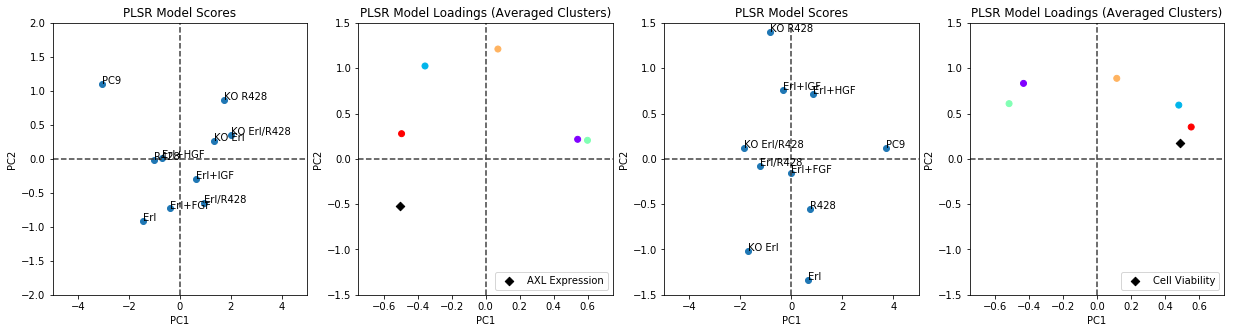

In [24]:
fig, axs = plt.subplots(1, 4,figsize=(21,5))
colors_ = cm.rainbow(np.linspace(0, 1, 5))
axs[0].scatter(PC1_scores_5axl,PC2_scores_5axl)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores_5axl[j], PC2_scores_5axl[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-5, 5])
axs[0].set_ylim([-2, 2])

axs[1].scatter(PC1_xload_5axl, PC2_xload_5axl, c=np.arange(5), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload_5axl, PC2_yload_5axl, color='#000000', marker='D', label='AXL Expression')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.75, 0.75])
axs[1].set_ylim([-1.5, 1.5])

axs[2].scatter(PC1_scores_5cv,PC2_scores_5cv)
for j, txt in enumerate(treatments):
    axs[2].annotate(txt, (PC1_scores_5cv[j], PC2_scores_5cv[j]))
axs[2].set_title('PLSR Model Scores')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')
axs[2].axhline(y=0, color='0.25', linestyle='--')
axs[2].axvline(x=0, color='0.25', linestyle='--')
axs[2].set_xlim([-5, 5])
axs[2].set_ylim([-1.5, 1.5])

axs[3].scatter(PC1_xload_5cv, PC2_xload_5cv, c=np.arange(5), cmap=colors.ListedColormap(colors_))
axs[3].scatter(PC1_yload_5cv, PC2_yload_5cv, color='#000000', marker='D', label='Cell Viability')
axs[3].legend(loc=4)
axs[3].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[3].set_xlabel('PC1')
axs[3].set_ylabel('PC2')
axs[3].axhline(y=0, color='0.25', linestyle='--')
axs[3].axvline(x=0, color='0.25', linestyle='--')
axs[3].set_xlim([-0.75, 0.75])
axs[3].set_ylim([-1.5, 1.5])
plt.show()